# Segmentación de Imágenes Usando la Transformada Watershed

La *Transformada Watershed* es un algortimo que permite realizar segmentación de imágenes. Así como el algoritmo Canny que trabajamos la clase pasada, es un paso preliminar a la aplicación de la transformada de Hough para la parametrización de los segmentos identificados.  

En la sección 11.5 del libro Digital Image Processing using Matlab de Gonzalez, Woods y Eddings que les subí a Sicua+ (les subí la versión de una versión más actual que la que había subido el lunes) encuentran una descripción del método y cómo implementarlo en Matlab. El objetivo de este taller es familiarizarse con algunos de los algoritmos de procesamiento de imágenes que permiten segmentar y parametrizar características de imágenes con el fin de desarrollar un método de granulometría de metales.  

Con el fin de satisfacer los objetivos planteados se le pide:  

* Leer el archivo de granulometría que va a analizar.  
* Reproducir el resultado mostrado en la Figura 11.28 de la referencia utilizando la herramienta OpenCV. Para esto se recomienda inicialmente revisar y reproducir:  
    * https://stackoverflow.com/questions/11294859/how-to-define-the-markers-for-watershed-in-opencv  
    * https://docs.opencv.org/3.3.1/d3/db4/tutorial_py_watershed.html  
* Ajustar el procedimiento para que segmente eficientemente las imágenes de granulometría.  
* Aplicar la transformada de Hough para parametrizar los segmentos identificados. Para esto se recomienda probar con círculos o elípses para determinar cuál tiene un mejor rendimiento.  
* Extraer la distribución de diámetros de los granos identificados.  
* Generar un histograma de la distribución de tamaño de grano encontrado.  

Populating the interactive namespace from numpy and matplotlib


Text(0.5,1,'Imagen Original')

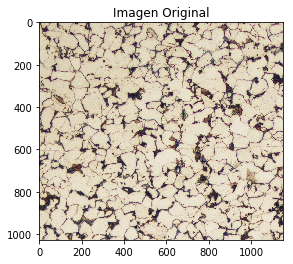

In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
%pylab inline
import scipy
from scipy import misc
from scipy import ndimage
from skimage import feature
from skimage.transform import (hough_circle, hough_circle_peaks)
from skimage.draw import circle_perimeter,circle
import os
from skimage import data, color

img = pylab.imread("recorte.jpg")
pylab.imshow(img, cmap = cm.Greys_r)
plt.title('Imagen Original', fontsize=12)


Text(0.5,1,'Imagen en blanco y negro')

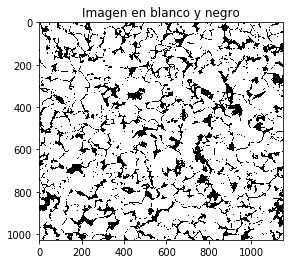

In [2]:
imfin=img
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
pylab.imshow(thresh, cmap = cm.Greys_r)
plt.title('Imagen en blanco y negro', fontsize=12)

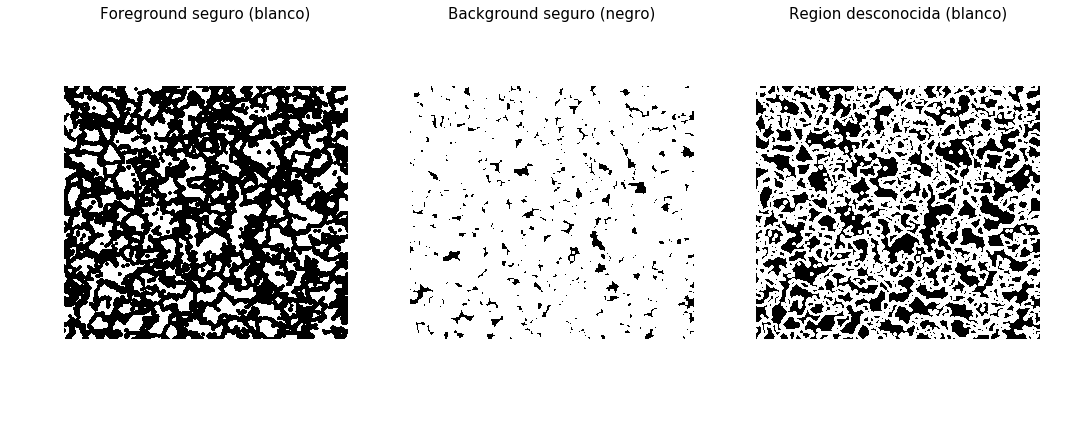

In [3]:
# sure background area
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)
sure_bg = cv2.dilate(opening,kernel,iterations=3)
sure_bg


dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
ret, sure_fg = cv2.threshold(dist_transform,0.2*dist_transform.max(),255,0)

sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)


fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(15, 6),
                                    sharex=True, sharey=True)

ax1.imshow(sure_fg, cmap=plt.cm.gray)
ax1.axis('off')
ax1.set_title('Foreground seguro (blanco)', fontsize=15)

ax2.imshow(sure_bg, cmap=plt.cm.gray)
ax2.axis('off')
ax2.set_title('Background seguro (negro)', fontsize=15)

ax3.imshow(unknown, cmap=plt.cm.gray)
ax3.axis('off')
ax3.set_title('Region desconocida (blanco)', fontsize=15)

fig.tight_layout()

plt.show()


In [4]:
# Marker labelling
ret, markers = cv2.connectedComponents(sure_fg)
# Add one to all labels so that sure background is not 0, but 1
markers = markers+1
# Now, mark the region of unknown with zero
markers[unknown==255] = 0



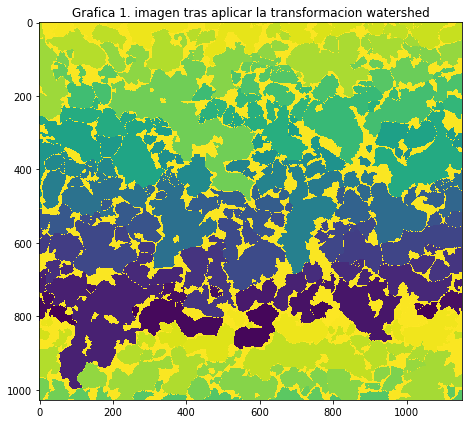

In [5]:
water = cv2.watershed(img,markers)

water[water == -1] = 0
water= water.astype(numpy.uint8)
water=water.max() - water


fig, (graf) = plt.subplots(nrows=1, ncols=1, figsize=(15, 6),sharex=True, sharey=True)
graf.imshow(water)
graf.set_title('Grafica 1. imagen tras aplicar la transformacion watershed')
fig.tight_layout()
plt.show()


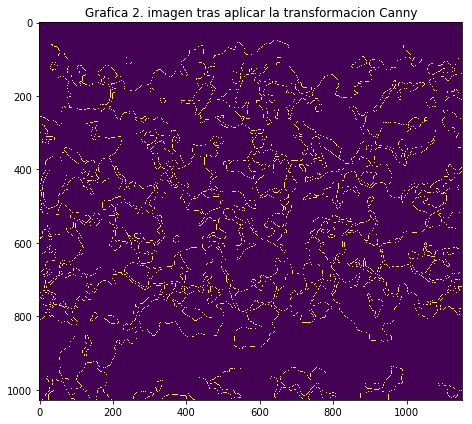

In [6]:
water.setflags(write=1)
water_fil=ndimage.gaussian_filter(water, sigma=2)

canny = feature.canny(water_fil, sigma=2)

fig, (graf2) = plt.subplots(nrows=1, ncols=1, figsize=(15, 6),sharex=True, sharey=True)
graf2.imshow(canny)
graf2.set_title('Grafica 2. imagen tras aplicar la transformacion Canny')
fig.tight_layout()
plt.show()

In [7]:
hough_radii = np.arange(0,200,1)
hough_res = hough_circle(canny, hough_radii)

accums, cx, cy, radii = hough_circle_peaks(hough_res, hough_radii,total_num_peaks=10)


imfin.setflags(write=1)
for center_y, center_x, radius in zip(cy, cx, radii):
    circy, circx = circle_perimeter(center_y, center_x, radius)
    imfin[circy, circx] = (220, 0, 0)

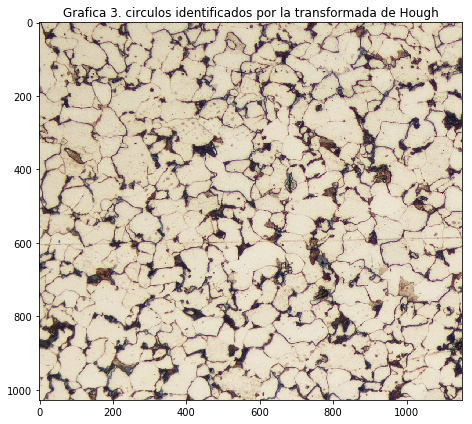

In [8]:
fig, (graf3) = plt.subplots(nrows=1, ncols=1, figsize=(15, 6),sharex=True, sharey=True)
graf3.imshow(imfin)
graf3.set_title('Grafica 3. circulos identificados por la transformada de Hough')
fig.tight_layout()
plt.show()

In [9]:
maximo=water.max()
cantidad=np.zeros(maximo+1)
longitud=(np.linspace(0,maximo,maximo+1)).astype(int)

for i in longitud:
    actual=(water==i)
    cantidad[i]=np.count_nonzero(actual)
cantidad
cantidad_real=cantidad[:-1]
cantidad_real_ord=sorted(cantidad_real)
promedio=np.mean(cantidad_real)
promedio

4413.0705882352941

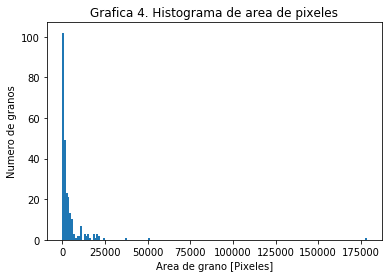

In [10]:
plt.hist(cantidad_real, bins='auto')
plt.xlabel('Area de grano [Pixeles]')
plt.ylabel('Numero de granos')
plt.title('Grafica 4. Histograma de area de pixeles')
pylab.savefig(os.path.join('graf4.png'), dpi=600)

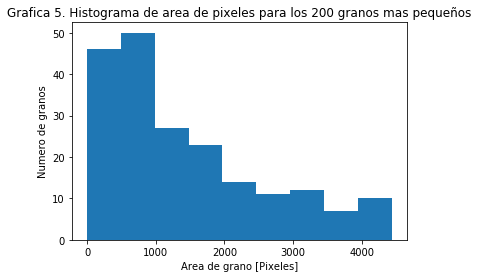

In [11]:
plt.hist(cantidad_real_ord[0:200], bins='auto')
plt.xlabel('Area de grano [Pixeles]')
plt.ylabel('Numero de granos')
plt.title('Grafica 5. Histograma de area de pixeles para los 200 granos mas pequeños')
pylab.savefig(os.path.join('graf5.png'), dpi=600)

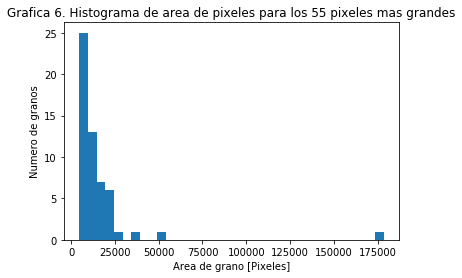

In [12]:
plt.hist(cantidad_real_ord[200:], bins='auto')
plt.xlabel('Area de grano [Pixeles]')
plt.ylabel('Numero de granos')
plt.title('Grafica 6. Histograma de area de pixeles para los 55 pixeles mas grandes')
pylab.savefig(os.path.join('graf6.png'), dpi=600)